In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')

<h4>Mikhail Mironov. Python Project 2.</h4>

<p>The first chunk is the code from the seminar as I used the same data.</p>

Let's try to replicate the [Cbonds USA Corporate Index](https://cbonds.ru/download/indexdocs/indexdescrs/1230) based on the prices of bonds ever included there

## 0. Data loading and preparation

In [2]:
# read index structure
# an International Securities Identification Number (ISIN) uniquely identifies a security.
structure = pd.read_excel(
    "seminar_data/cbonds-usa-corporate-index.xlsx", sheet_name="structure"
)

structure['Index Structure Date'] = pd.to_datetime(
    structure['Index Structure Date'], format="%d.%m.%Y"
)

structure.head()

,Index Structure Date,Issue name,ISIN,"Issue amount, USDmn",Issue currency,Maturity date
0,2023-04-01,"AT&T Inc, 1.65% 1feb2028, USD",US00206RKG64,2250.000,USD,2028-02-01 00:00:00
1,2023-04-01,"AT&T Inc, 1.7% 25mar2026, USD",US00206RML32,3000.000,USD,2026-03-25 00:00:00
2,2023-04-01,"AT&T Inc, 2.25% 1feb2032, USD",US00206RKH48,2500.000,USD,2032-02-01 00:00:00
3,2023-04-01,"AT&T Inc, 2.3% 1jun2027, USD",US00206RJX17,2500.000,USD,2027-06-01 00:00:00
4,2023-04-01,"AT&T Inc, 2.55% 1dec2033, USD",US00206RMM15,3754.161,USD,2033-12-01 00:00:00


In [3]:
# read bonds quotes
quotes = pd.read_csv(
    "seminar_data/quotes.csv",
    usecols=['Trade date', 'Indicative price, %', 'ISIN', 'ACI'],
    parse_dates=['Trade date']
)


quotes.drop_duplicates(inplace=True)
quotes.head()

,Trade date,"Indicative price, %",ACI,ISIN
0,2023-04-10,88.02065,6.33,US00206RKG64
1,2023-04-07,88.54125,6.05,US00206RKG64
2,2023-04-06,88.87270,5.96,US00206RKG64
3,2023-04-05,89.00250,5.87,US00206RKG64
4,2023-04-04,88.69000,5.78,US00206RKG64


## 1. From net to dirty prices

* Accrued coupon interest (ACI, Accrued Interest) is a value measured in monetary units, and characterizing the part of coupon income, which has "accrued" from the beginning of the coupon period

* In most markets, bonds are traded at net prices (excluding ACI) and sales transactions are made at a dirty price (including ACI), which means that when the transaction price of the bond for the buyer is made up of two components: the market price and the accumulated coupon income for the relevant period


* Be careful! Many data vendors mess up their data. Bond price estimates can be distorted by short-term liquidity shortages in the markets.

In [4]:
bonds_desc = pd.read_excel(
    "seminar_data/cbonds-usa-corporate-index.xlsx",
    sheet_name='bonds_desc_15.04.2023',
    usecols=['ISIN', 'Coupon frequency', 'Nominal / Minimum Settlement Amount']
)


# create mapping isin: nominal/settlement amount
mapping_isin_nominal = dict(zip(bonds_desc['ISIN'], bonds_desc['Nominal / Minimum Settlement Amount']))
mapping_isin_nominal.update

# calculate ACI as % of nominal/settling amount
quotes['ACI, %'] = quotes['ACI'] * 100 / quotes['ISIN'].map(mapping_isin_nominal)

In [5]:
example_isin ='US00206RCP55'

example = quotes.set_index(['ISIN', 'Trade date']).sort_index().loc[example_isin,:]

Text(0.5, 1.0, 'US00206RCP55 price decomposition')

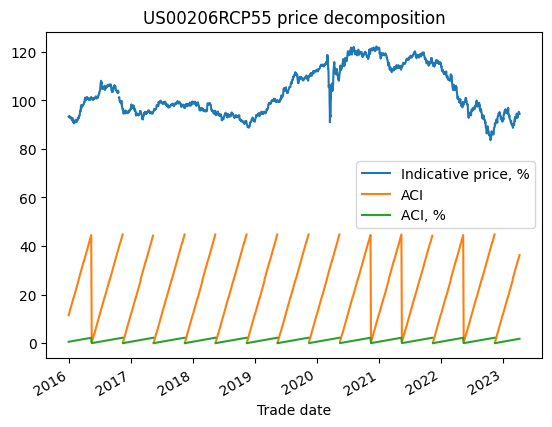

In [6]:
example.plot()
plt.title(f'{example_isin} price decomposition')

In [7]:
example['ACI, %'].fillna(0, inplace=True) # filling the gaps
coupon_event = example['ACI, %'] > example['ACI, %'].shift(-1) # time of coupon payment = zeroing of ACI
coupons = example['ACI, %'][coupon_event] + example['ACI, %'].shift(-2)[coupon_event] # T+2 settlement
coupon_yield = coupons / example['Indicative price, %'] # make adjustment for nominal as ACI not in % of nominal

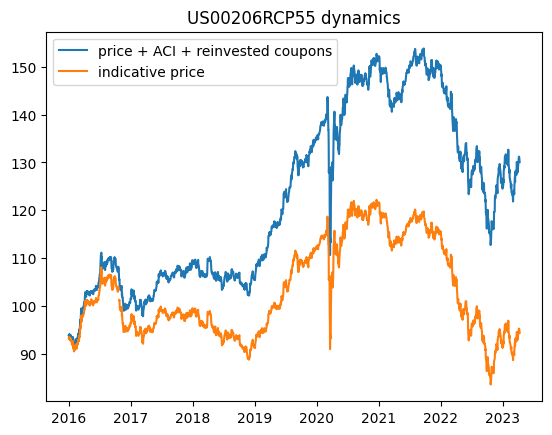

In [8]:
rets = example['Indicative price, %'].pct_change().fillna(0) + coupon_yield.fillna(0)
price = pd.Series((np.ones_like(rets) + rets), index=example.index).cumprod() * example['Indicative price, %'][0]
price = (price + example['ACI, %'][~coupon_event]).fillna(method='ffill')
plt.plot(price, label='price + ACI + reinvested coupons')
plt.plot(example['Indicative price, %'], label='indicative price')
plt.title(f'{example_isin} dynamics')
plt.legend()

In [9]:
# wrap into function to calculate total bond return / dirty price

def calc_tr(quotes):
    '''
    Calculates dirty prices 
    
    Input - DataFrame,  columns: 'Trade date', 'ISIN', 'Indicative price, %', 'ACI, %'
    Output - sorted Initial DataFrame with additional 'dirty_price' column
    '''
    q = quotes.copy()
    q['dirty_price'] = np.zeros_like(q.ISIN)
    isins = q.ISIN.unique()
    q = q.set_index(['ISIN', 'Trade date']).sort_index()
    
    for isin in isins:
        dt = q.loc[isin,:]
        dt['ACI, %'].fillna(0, inplace=True)
        coupon_event = dt['ACI, %'] > dt['ACI, %'].shift(-1)
        coupons = dt['ACI, %'][coupon_event] + dt['ACI, %'].shift(-2)[coupon_event]
        coupon_yield = coupons / dt['Indicative price, %'] # make adjustment for nominal, ACI not in % of nominal

        rets = dt['Indicative price, %'].pct_change().fillna(0) + coupon_yield.fillna(0) # cbonds provides incorrect data
        price = pd.Series((np.ones_like(rets) + rets), index=dt.index).cumprod() * dt['Indicative price, %'][0]
        price = (price + dt['ACI, %'][~coupon_event]).fillna(method='ffill')
        q.loc[isin,'dirty_price'] = price.values

    return q

## 2. Constructing index

In [10]:
import vectorbt as vbt

In [11]:
# create dataframe of dirty prices
prices = calc_tr(quotes).dirty_price.unstack().T.fillna(method='ffill')

In [12]:
structure["Index Structure Date"] = pd.to_datetime(structure["Index Structure Date"])
structure.groupby("Index Structure Date")["Issue amount, USDmn"].sum()

Index Structure Date
2016-01-01     316454.000
2016-02-01     336138.000
2016-03-01     348638.000
2016-04-01     371088.000
2016-05-01     380088.000
                 ...     
2022-12-01    1668927.000
2023-01-01    1653712.000
2023-02-01    1671757.000
2023-03-01    1678007.000
2023-04-01    1697401.069
Name: Issue amount, USDmn, Length: 88, dtype: float64

In [13]:
# Cbonds index is weighted by outstanding amount
amount = structure.groupby("Index Structure Date")[
    "Issue amount, USDmn"
].sum()  # sum of outstanding value of bonds at each date

structure['weights'] = structure.apply(
    lambda x: x['Issue amount, USDmn'] / amount.loc[x['Index Structure Date']], 
    axis=1
) # weights of bonds at each date

# transforming to DataFrame: columns - bonds, rows - dates, values - weights

w = structure[['Index Structure Date', 'ISIN', 'weights']].set_index(['Index Structure Date', 'ISIN'])
w = w.unstack().fillna(0)
w = w.reindex(prices.index).fillna(method='ffill')
w = w['weights'][prices.columns]

In [14]:
# index, that we are trying to replicate
cbonds_index = pd.read_excel(
    "seminar_data/cbonds-usa-corporate-index.xlsx", sheet_name="index_value", index_col=0
)

In [15]:
bond_pf = vbt.Portfolio.from_orders(
    close=prices,
    size=w,
    size_type='targetpercent',
    direction='longonly',
    group_by=True,
    cash_sharing=True
)

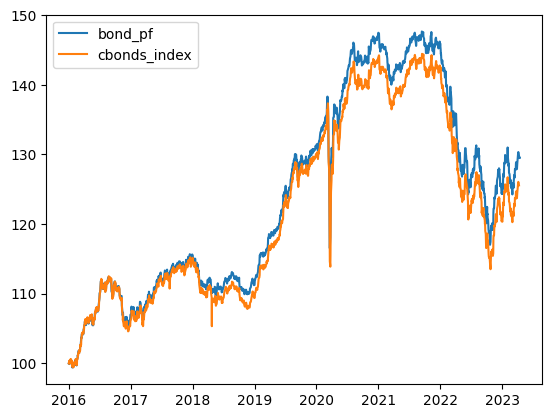

In [16]:
plt.plot(bond_pf.value(), label='bond_pf')
plt.plot(cbonds_index, label='cbonds_index')
plt.legend()

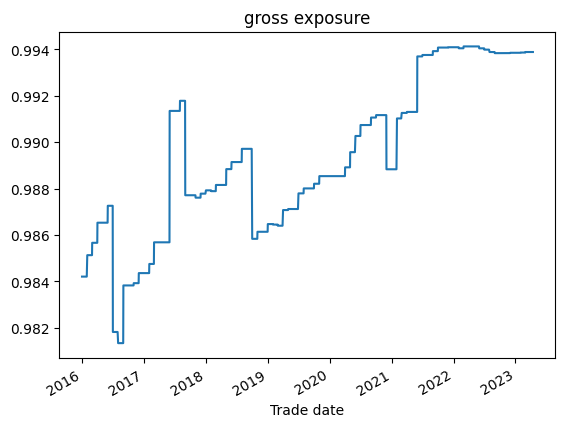

In [17]:
# we replicated ~99% of index

w.sum(axis=1).plot()
plt.title('gross exposure')
plt.show()

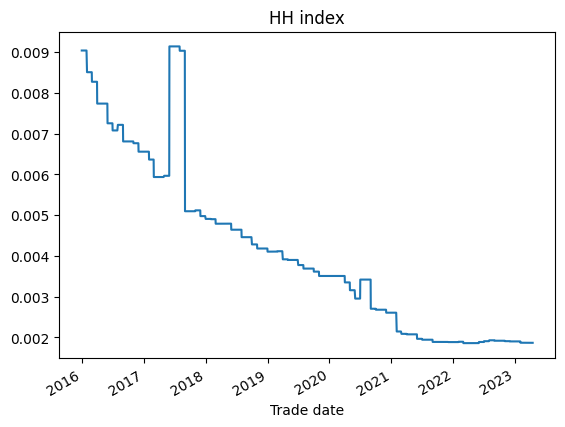

In [18]:
# calculate Herfindahl-Hirschman index to estimate portfolio concentration

(w ** 2).sum(axis=1).plot()
plt.title('HH index')
plt.show()

In [19]:
# time of returns max divergence is crisis time

(bond_pf.value().pct_change() - cbonds_index['Cbonds USA Corporate USD Index'].pct_change()).idxmax()

Timestamp('2020-03-25 00:00:00')

In [20]:
# calculate tracking error

tracking_error = (bond_pf.value().pct_change() - cbonds_index['Cbonds USA Corporate USD Index'].pct_change()).std() * 252 ** 0.5

print('Tracking error - {:0.2f}%'.format(tracking_error*100))

Tracking error - 11.63%


Discrepancy may be due to errors in the raw data, incomplete replication of the portfolio

# Project 2 - Quantitative bond strategy

### Task
- Build a quantitative strategy and overtake the Cbonds Corporate USD Index by Sharpe Ratio on backtest
- Use any idea, any additional features and any quantitative framework you want
- Backtesting: Sharpe & Calmar Ratios, Accumulted Return / Maximum Drawdown
- Risk Measures: Calculate 5% VaR using PCA and backtest it
- Diversification Measures: Calculate dynamics of Herfindahl-Hirschman Index and Intra-portfolio correlation (IPC), compare it to Cbonds Index
- Save all your backtest attempts and calculate the probability of backtest overfitting. Would you trust your results?
- Results: Jupyter Notebook with detailed comments and docstrings where applicable. **Please describe in the beginning of the file the methodology you used!**
- Deadline: 31.03.2024 23:59 MSK. Please send you code to igor.evsin@squants.education

### Data
- Data Frame: 2016-2021 – training + validation (if applicable), 2022-today – testing
- Dataset: see attached to this notebook
- Transaction cost: 0,1% per trade, no fixed costs

### Limits on backtest
- Initial Capital: mn$20
- Total return > 0
- Max Drawdown: < 10%
- Max Drawdown Period: < 3M
- No leverage
- Execution: Next Open price

### Grading
- Try to write code elegantly - points will be taken off for shitty coding.
- Vectorize calculations! (we will take points off for reckless use of loops)
- Points will be deducted for breaking backtest limits
- Points will be deducted for having biases in the backtest
- Those who get a Sharpe 2x< on the backtest without obvious biases will get extra points

<h4>Start of the solution</h4>

<p>Initially I wanted to download data for bonds traded on MOEX and use CBonds Russia indecies to benchmark anything I end up doing, but I was unable to find the exact list of bonds included into the index, so I ended up just sticking to the dataset from the seminar.</p>

<p>Honestly, I am a newb in bonds, so I won't do any complicated things, as far as I understand Indicative price, % indicates the price in percentage of the total Face value which is paid at maturity, so what we want is to enter at low percentages and exit at high percentages (might be completely wrong, but I will proceed with this)</p>

In [21]:
from datetime import datetime
from typing import *


import polars as pl
import pandas as pd
import matplotlib.pyplot as plt


df_quotes = pd.read_csv(
    "seminar_data/quotes.csv"
)

# I will use already clean prices, calculated with code above
prices.head(2)

ISIN,US00206RCG56,US00206RCM25,US00206RCN08,US00206RCP55,US00206RCQ39,US00206RCT77,US00206RDQ20,US00206RDS85,US00206RGQ92,US00206RHJ41,...,USU88030BD97,USU88030BJ67,USU88030BM96,USU88868AW19,USU9094LAC29,USU9094LAD02,USU91473AA32,USV7780TAC72,XS2116430997,XS2121367192
Trade date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,92.9980,97.4585,96.1095,93.8500,92.2725,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,93.6185,97.8185,96.5430,94.0925,93.3865,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


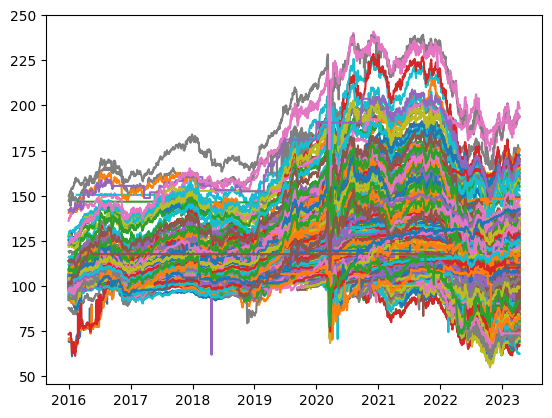

In [22]:
plt.plot(prices.index, prices)
plt.show()

In [23]:
# as a risk free I will use 3 months Treasury bills
dtb3 = pd.read_csv("seminar_data/DTB3.csv")

df_returns = prices.pct_change().iloc[1:, :]
df_returns.head(1)

ISIN,US00206RCG56,US00206RCM25,US00206RCN08,US00206RCP55,US00206RCQ39,US00206RCT77,US00206RDQ20,US00206RDS85,US00206RGQ92,US00206RHJ41,...,USU88030BD97,USU88030BJ67,USU88030BM96,USU88868AW19,USU9094LAC29,USU9094LAD02,USU91473AA32,USV7780TAC72,XS2116430997,XS2121367192
Trade date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.006672,0.003694,0.00451,0.002584,0.012073,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The following problem is solved on the window of size 180 days and then these weights are used to hold portfolio of bonds for 30 days, and then rebalancing happens again:

$$\frac{w^T \hat{R}} {w \hat{\Omega} w^T} \rightarrow max_{w}$$
$$\text{s.t.} \sum_{i=1}^N{w_i} = 1$$
$$w_i \ge 0$$

<h4>Rebalance portfolio of bonds with these weights, update weights each month</h4>

In [24]:
from dataclasses import dataclass
from scipy.optimize import minimize
from functools import partial


@dataclass
class Result:
    w: np.array
    func: np.float64


def sharpe_objective(W, df_returns: pd.DataFrame) -> float:
    sigma_p = np.sqrt(W @ df_returns.cov() @ W.T)
    R = df_returns.mean(axis=0)

    return -np.dot(W, R) / sigma_p


def weights_constr(W):
    return W.sum() - 1


def optimize_portfolio(df_returns: pd.DataFrame) -> Result:
    # select all columns (bonds) containing no NaNs
    all_cols: List[str] = df_returns.columns
    cols: List[str] = df_returns.columns[df_returns.isnull().any() == False].tolist()
    na_cols: List[str] = list(set(all_cols) - set(cols))

    constrs = [{"type": "eq", "fun": weights_constr}]

    x0 = [1 / len(cols)] * len(cols) # start from equally weighted portfolio
    bounds = [(0, 1)] * len(cols)  # no shorting bonds

    sol = minimize(
        fun=partial(sharpe_objective, df_returns=df_returns[cols]), # Returns to risk ratio
        x0=x0,
        constraints=constrs,
        bounds=bounds,
    )

    weights = []
    w: Iterator = iter(sol.x)

    for col in all_cols:
        weights.append(0 if col in na_cols else next(w))

    return Result(
        w=np.array(weights),
        func=-sol.fun
    )

In [25]:
res: Result = optimize_portfolio(
    df_returns=df_returns[:500]
)

In [26]:
def hold_balanced_portfolio(df_test: pd.DataFrame, res: Result) -> np.float64:
    """Calculate performance of the weights on df_test. Returns 1 + return"""
    W: Dict[str, np.float64] = res.w
    test_returns = (1 + df_test).prod().values
    return W @ test_returns.T

In [27]:
hold_balanced_portfolio(
    df_test=df_returns.iloc[500:510],
    res=res
)

1.0030642333011368

<h4>Now perform this rebalancing every 180 days and hold bonds for 30 days before next rebalancing</h4>

<p>This takes some time, so in order not to wait a lot, I ran training weights and backtesting in a separate optimize_portfolios.py file with multiprocessing, I could have done it here, but tqdm with multiprocessing and notebook is a nuclear mix, so it is better to run this script from terminal</p>

<p>Run from root directory</p>

<i>python optimize_portfolios.py</i>

In [28]:
# load backtest.json file
import json

with open("backtest.json", "r") as file:
    data = json.load(file)["res"]

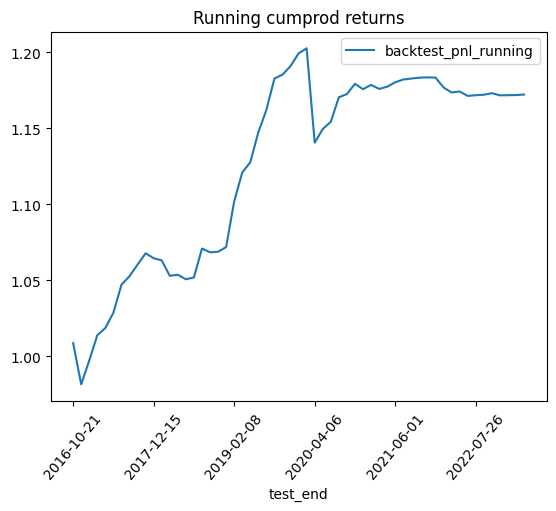

In [29]:
df_backtest = pd.DataFrame(data)
df_backtest["backtest_pnl_running"] = df_backtest["backtest_pnl"].cumprod()

df_backtest.plot(
    x="test_end", y="backtest_pnl_running"
)

plt.title("Running cumprod returns")
plt.xticks(rotation=50)
plt.show()

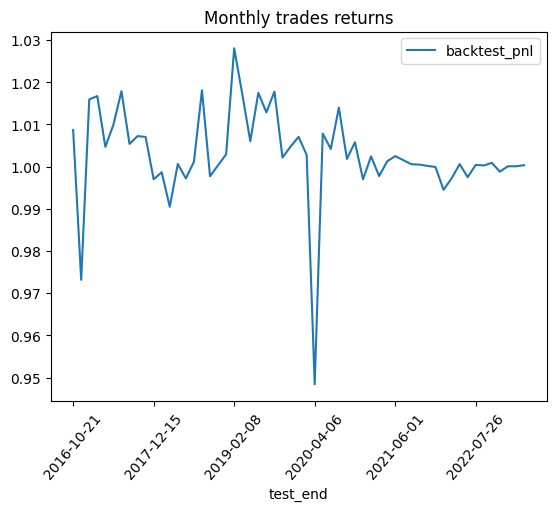

In [30]:
df_backtest.plot(
    x="test_end", y="backtest_pnl", title="Monthly trades returns"
)

plt.xticks(rotation=50)
plt.show()

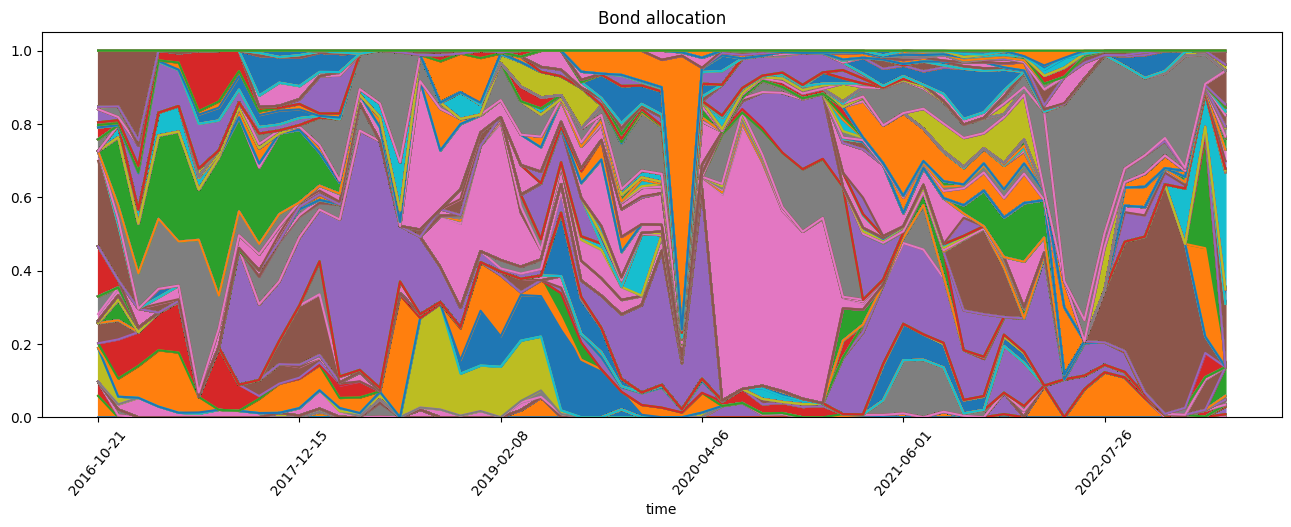

In [31]:
df_weights = pd.DataFrame(
    data=np.array(df_backtest["weights"].tolist())
)


df_weights["time"] = df_backtest["test_end"]

df_weights.plot.area(
    x="time", y=[col for col in df_weights.columns if col != "time"], 
    stacked=True, legend=False, title="Bond allocation", figsize=(16, 5)
)

plt.xticks(rotation=50)
plt.show()

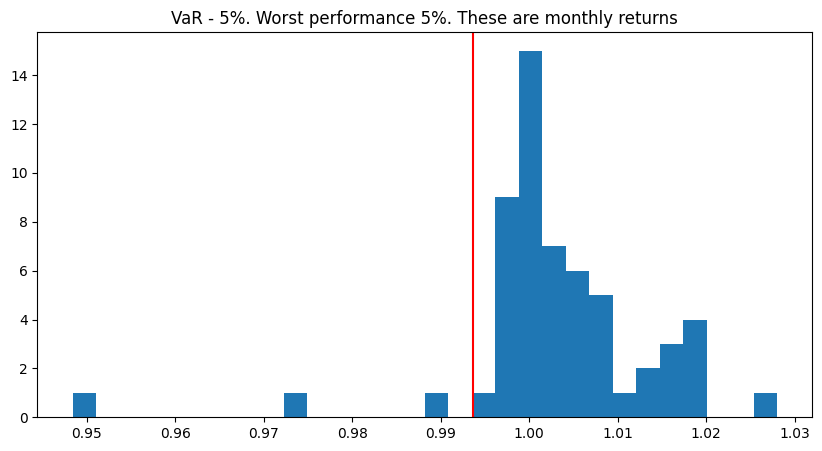

In [32]:
# VaR
df_backtest["backtest_pnl"].hist(bins=30, grid=False, figsize=(10, 5))

plt.axvline(
    df_backtest["backtest_pnl"].quantile(.05), color="red"
)

plt.title("VaR - 5%. Worst performance 5%. These are monthly returns")
plt.show()

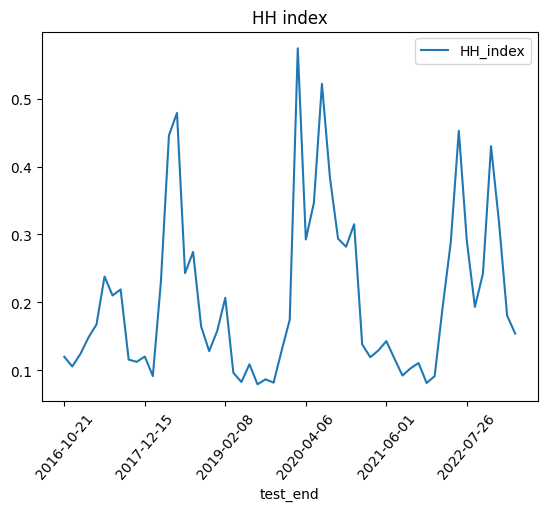

In [33]:
# HH index
df_backtest["HH_index"] = df_backtest["weights"].apply(
    lambda weights: sum([w**2 for w in weights])
)

df_backtest.plot(x="test_end", y="HH_index", title="HH index")
plt.xticks(rotation=50)
plt.show()